# E-Waste Image Classification Using EfficientNetV2B0

## Problem Statement
E-waste (electronic waste) is rapidly becoming a serious environmental and health issue around the world. Proper sorting and categorization of e-waste is essential for efficient recycling and disposal, but manual classification is error-prone and labor-intensive.

This project aims to build an automated e-waste classification system using artificial intelligence and machine learning. By training a deep learning model on images of different types of e-waste, we can identify and categorize them accurately.


## Key Challenges:
 - 53 million metric tons generated globally in 2021 
 - Only 17% is properly recycled 
 - Toxic materials harm environment 

## Aim 
To develop an AI system that automatically classifies e-waste into categories for efficient recycling.

##  Dataset Overview

###  Dataset Name: e-waste-dataset  
###  Source:  https://www.kaggle.com/datasets/akshat103/e-waste-image-dataset 

Each directory contains 10 subfolders, each representing one class of e-waste:

- PCB (Printed Circuit Board)
- Player
- Battery
- Microwave
- Mobile
- Mouse
- Printer
- Television
- Washing Machine
- Keyboard

</div>

## Expected Outcomes:
- 90%+ classification accuracy 
- Real-time processing capability 
- User-friendly interface 

## Technical Approach 
 We'll use transfer learning with EfficientNetV2B0 model:

## Why EfficientNet? 
 - State-of-the-art image classification 
 - Lightweight yet accurate 
 - Pre-trained on ImageNet 


## Setup and Installation 
First install required packages:

In [1]:
!pip install tensorflow gradio numpy matplotlib seaborn scikit-learn pillow --quiet
print("All packages installed successfully!")

All packages installed successfully!


## Data Loading 
Let's load our e-waste dataset:

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B0
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image
import os
import pathlib

## Define dataset paths

In [3]:
dataset_dir = pathlib.Path("e-waste-dataset")
train_dir = dataset_dir / "train"
test_dir = dataset_dir / "test"
val_dir = dataset_dir / "val"

## Dataset parameters

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

## Load datasets

In [5]:
print("\nLoading training data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("\nLoading validation data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("\nLoading test data...")
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)



Loading training data...
Found 2400 files belonging to 10 classes.

Loading validation data...
Found 300 files belonging to 10 classes.

Loading test data...
Found 300 files belonging to 10 classes.


## Show class names

In [6]:
class_names = train_ds.class_names
print(f"\nClass names: {class_names}")
print(f"Total classes: {len(class_names)}")


Class names: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']
Total classes: 10


## Data Exploration 
Let's understand our dataset better:

Count images in each set

In [7]:
def count_images(directory):
    counts = {}
    for class_name in class_names:
        counts[class_name] = len(os.listdir(directory / class_name))
    return counts

print("\nTraining images per class:")
print(count_images(train_dir))

print("\nValidation images per class:")
print(count_images(val_dir))

print("\nTest images per class:")
print(count_images(test_dir))


Training images per class:
{'Battery': 240, 'Keyboard': 240, 'Microwave': 240, 'Mobile': 240, 'Mouse': 240, 'PCB': 240, 'Player': 240, 'Printer': 240, 'Television': 240, 'Washing Machine': 240}

Validation images per class:
{'Battery': 30, 'Keyboard': 30, 'Microwave': 30, 'Mobile': 30, 'Mouse': 30, 'PCB': 30, 'Player': 30, 'Printer': 30, 'Television': 30, 'Washing Machine': 30}

Test images per class:
{'Battery': 30, 'Keyboard': 30, 'Microwave': 30, 'Mobile': 30, 'Mouse': 30, 'PCB': 30, 'Player': 30, 'Printer': 30, 'Television': 30, 'Washing Machine': 30}


 ## Visualize samples 

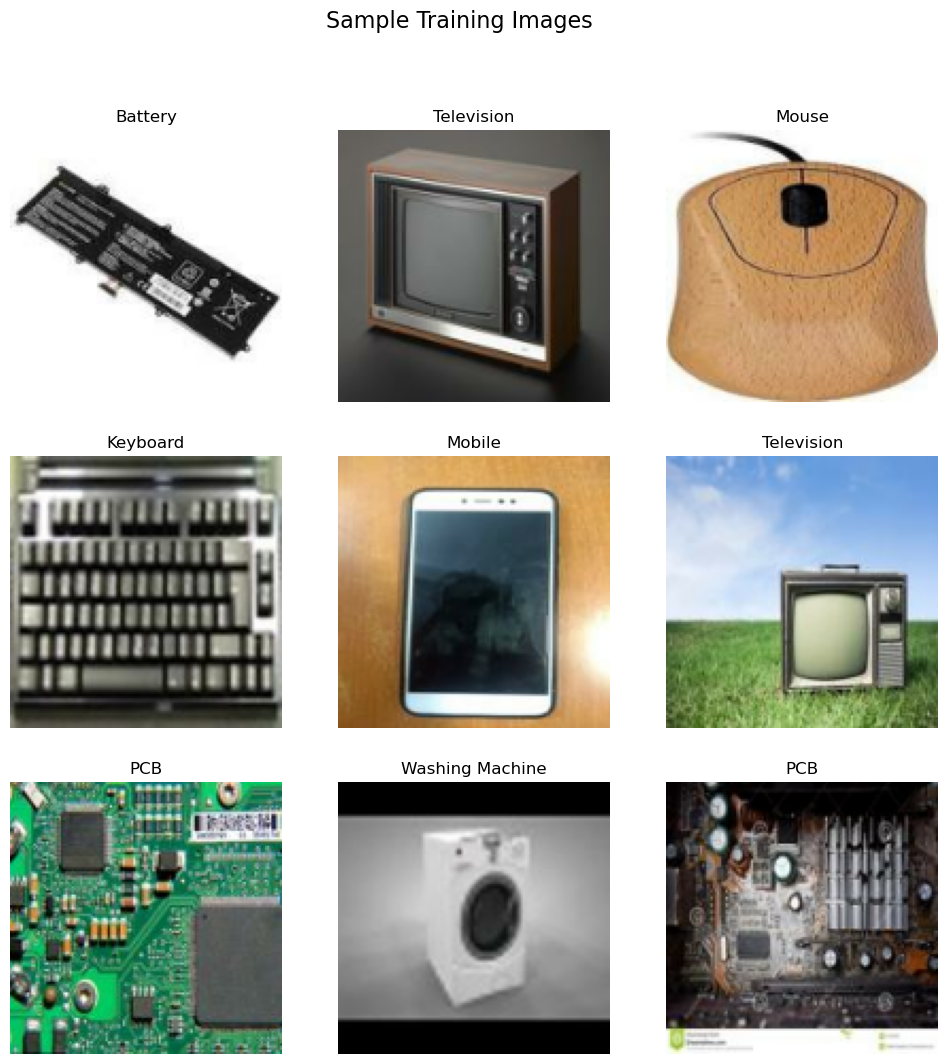

In [8]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Training Images", fontsize=16)
plt.show()

## Data Augmentation 
To improve model generalization:

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

## Visualize augmented images

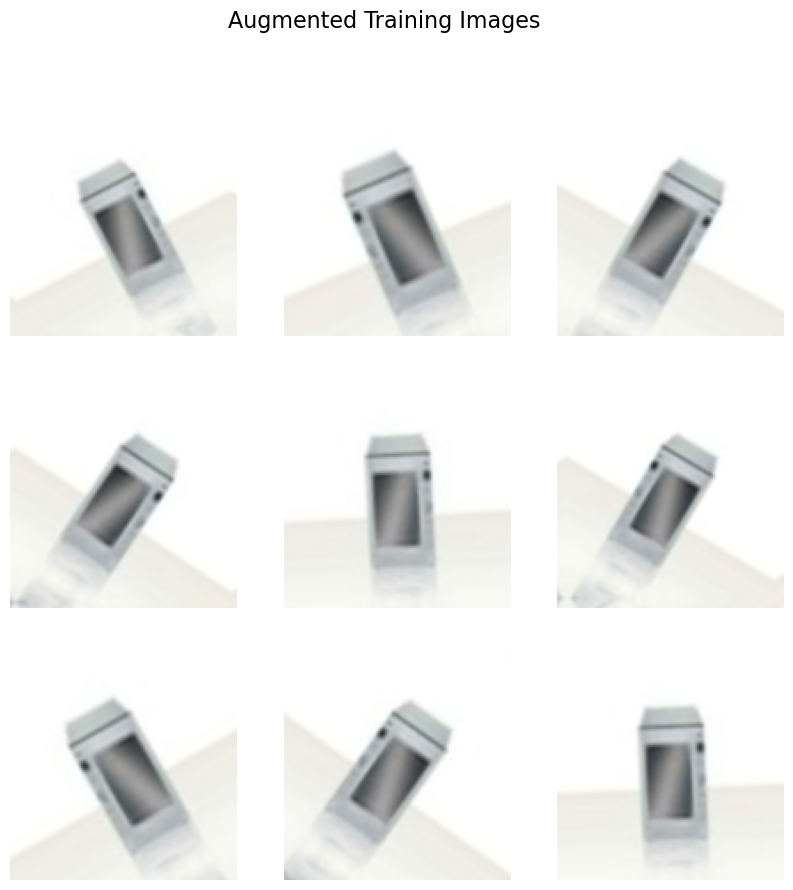

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.suptitle("Augmented Training Images", fontsize=16)
plt.show()

## Model Architecture 
 Building our EfficientNetV2B0 model:

Load base model

In [11]:
base_model = EfficientNetV2B0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

 Freeze layers

In [12]:
base_model.trainable = True
print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Freezing first {int(len(base_model.layers)*0.7)} layers")

for layer in base_model.layers[:int(len(base_model.layers)*0.7)]:
    layer.trainable = False

Total layers in base model: 270
Freezing first 189 layers


 Build complete model

In [13]:
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

 Compile model

In [14]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

 Model summary

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 3,109,114 (11.86 MB)

 Non-trainable params: 2,823,008 (10.77 MB)

## Training 
Let's train our model:

 Callbacks

In [16]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_accuracy'
)

Training parameters

In [17]:
EPOCHS = 30

 Train model

In [18]:
print("\nStarting model training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)


Starting model training...
Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.2256 - loss: 2.1821

75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 309ms/step - accuracy: 0.2277 - loss: 2.1782 - val_accuracy: 0.8167 - val_loss: 1.1797
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7391 - loss: 1.1214

75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - accuracy: 0.7395 - loss: 1.1196 - val_accuracy: 0.9000 - val_loss: 0.5536
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8439 - loss: 0.6506

75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 239ms/step - accuracy: 0.8440 - loss: 0.6498 - val_accuracy: 0.9300 - val_loss: 0.3567
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8833 - loss: 0.4657

75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 246ms/step - accuracy: 0.8833 - loss: 0.4653 - val_accuracy: 0.9467 - val_loss: 0.2659
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9124 - loss: 0.3489

75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 300ms/step - accuracy: 0.9124 - loss: 0.3488 - val_accuracy: 0.9500 - val_loss: 0.2155
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 352ms/step - accuracy: 0.9140 - loss: 0.2978 - val_accuracy: 0.9500 - val_loss: 0.1911
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9226 - loss: 0.2610

75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 462ms/step - accuracy: 0.9227 - loss: 0.2608 - val_accuracy: 0.9633 - val_loss: 0.1610
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 654ms/step - accuracy: 0.9450 - loss: 0.2109 - val_accuracy: 0.9567 - val_loss: 0.1518
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 386ms/step - accuracy: 0.9412 - loss: 0.1953 - val_accuracy: 0.9600 - val_loss: 0.1430
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 403ms/step - accuracy: 0.9562 - loss: 0.1574 - val_accuracy: 0.9567 - val_loss: 0.1381
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 391ms/step - accuracy: 0.9603 - loss: 0.1395 - val_accuracy: 0.9633 - val_loss: 0.1263
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 404ms/step - accuracy: 0.9729 - loss: 0.1081 - val_accuracy: 0.9633 - val_loss: 0.1180
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 397ms/step - accuracy: 0.9693 - loss: 0.1130 - val_accuracy: 0.9600 - val_loss: 0.1159
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 400ms/step - accuracy: 0.9766 - loss: 0.0895 - val_accuracy: 

75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 402ms/step - accuracy: 0.9772 - loss: 0.0888 - val_accuracy: 0.9667 - val_loss: 0.1146
Epoch 17/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 388ms/step - accuracy: 0.9788 - loss: 0.0800 - val_accuracy: 0.9667 - val_loss: 0.1142
Epoch 18/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9811 - loss: 0.0777

75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 408ms/step - accuracy: 0.9811 - loss: 0.0776 - val_accuracy: 0.9700 - val_loss: 0.1101
Epoch 19/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 385ms/step - accuracy: 0.9782 - loss: 0.0702 - val_accuracy: 0.9667 - val_loss: 0.1185
Epoch 20/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 390ms/step - accuracy: 0.9805 - loss: 0.0705 - val_accuracy: 0.9700 - val_loss: 0.1166
Epoch 21/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9825 - loss: 0.0603

75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 394ms/step - accuracy: 0.9825 - loss: 0.0603 - val_accuracy: 0.9733 - val_loss: 0.1148
Epoch 22/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 384ms/step - accuracy: 0.9877 - loss: 0.0486 - val_accuracy: 0.9667 - val_loss: 0.1232
Epoch 23/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 398ms/step - accuracy: 0.9830 - loss: 0.0581 - val_accuracy: 0.9700 - val_loss: 0.1158


 Load best model

In [19]:
model = tf.keras.models.load_model('best_model.h5')
print("\nBest model loaded!")


Best model loaded!


## Training Visualization 
 Plot training progress:

Prepare plot data

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

 Create plots

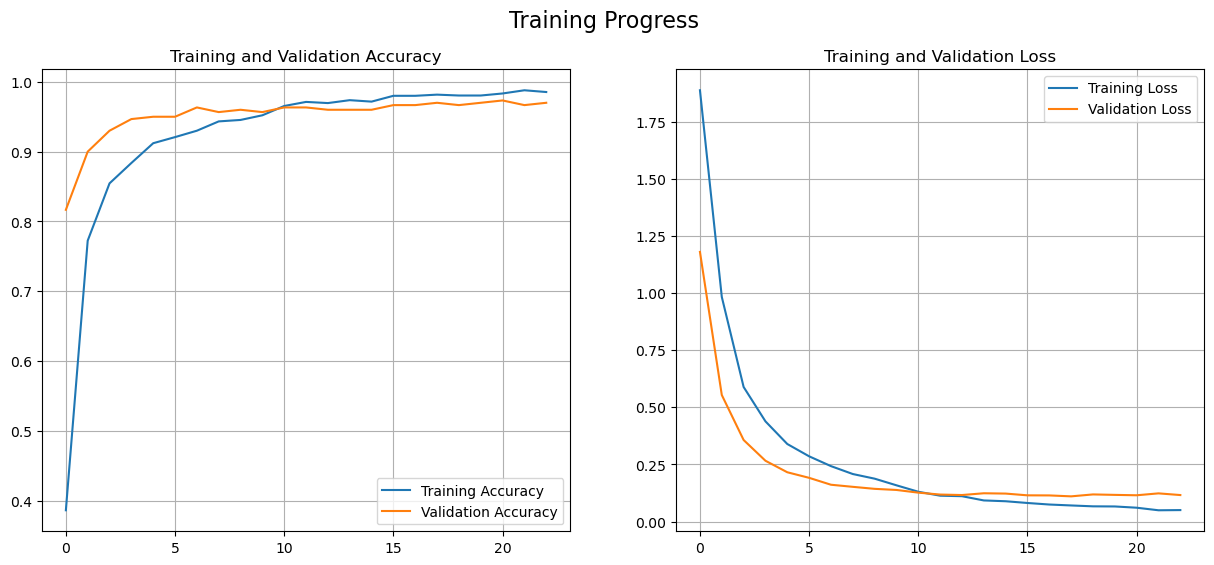

In [21]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.suptitle("Training Progress", fontsize=16)
plt.show()


## Evaluation 
 Test model performance:

Evaluate on test set

In [22]:
print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Evaluating on test set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9485 - loss: 0.1752

Test Accuracy: 0.9533
Test Loss: 0.1403


Predictions

In [23]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step


Classification report

In [24]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
                 precision    recall  f1-score   support

        Battery       0.90      0.93      0.92        30
       Keyboard       1.00      0.93      0.97        30
      Microwave       0.94      0.97      0.95        30
         Mobile       1.00      0.97      0.98        30
          Mouse       0.97      0.97      0.97        30
            PCB       0.88      0.97      0.92        30
         Player       0.93      0.93      0.93        30
        Printer       0.94      0.97      0.95        30
     Television       1.00      0.93      0.97        30
Washing Machine       1.00      0.97      0.98        30

       accuracy                           0.95       300
      macro avg       0.96      0.95      0.95       300
   weighted avg       0.96      0.95      0.95       300



Confusion matrix

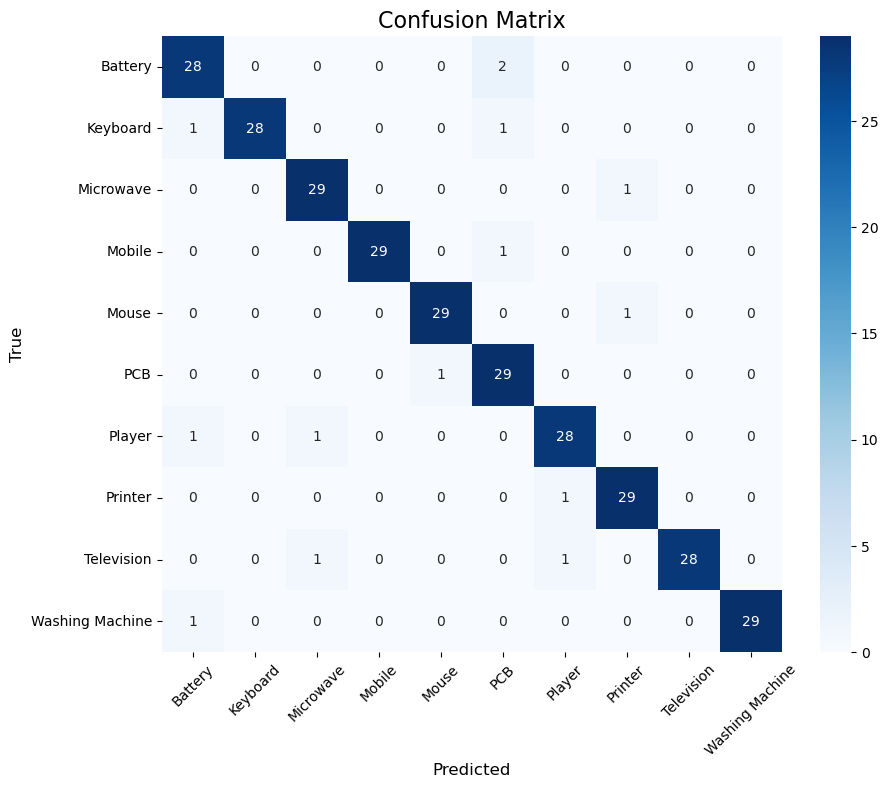

In [25]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## Deployment 
 Create a Gradio interface:

In [26]:
def classify_image(img):
    """Classify e-waste image and return results"""
    # Preprocess image
    img = img.resize(IMG_SIZE)
    img_array = np.array(img, dtype=np.float32)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    prediction = model.predict(img_array)
    pred_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    # Get top 3 predictions
    top3_indices = np.argsort(prediction[0])[-3:][::-1]
    top3_classes = [class_names[i] for i in top3_indices]
    top3_confidences = [prediction[0][i] for i in top3_indices]
    
    # Create result dictionary
    result = {
        "Prediction": pred_class,
        "Confidence": f"{confidence:.2%}",
        "Top Predictions": [
            f"{name}: {conf:.2%}" for name, conf in zip(top3_classes, top3_confidences)
        ]
    }
    
    return result

Create interface

In [27]:
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", label="Upload E-Waste Image"),
    outputs=[
        gr.Textbox(label="Predicted Class"),
        gr.Textbox(label="Confidence Score"),
        gr.Label(label="Top 3 Predictions")
    ],
    title="E-Waste Classification System",
    description="Upload an image of electronic waste to classify it into proper recycling categories",
    examples=[
        [str(test_dir / "Battery" / os.listdir(test_dir / "Battery")[0])],
        [str(test_dir / "Mobile" / os.listdir(test_dir / "Mobile")[0])]
    ],
    allow_flagging="never"
)

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\interface.py:419: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


 Launch interface

In [ ]:
print("\nLaunching Gradio interface...")
iface.launch(share=True)


Launching Gradio interface...
* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Traceback (most recent call last):
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py", line 2230, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py", line 1957, in postprocess_data
    self.validate_outputs(block_fn, predictions)  # type: ignore
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Traceback (most recent call last):
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py", line 2230, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py", line 1957, in postprocess_data
    self.validate_outputs(block_fn, predictions)  # type: ignore
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Traceback (most recent call last):
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py", line 2230, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py", line 1957, in postprocess_data
    self.validate_outputs(block_fn, predictions)  # type: ignore
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Traceback (most recent call last):
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py", line 2230, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\gradio\blocks.py", line 1957, in postprocess_data
    self.validate_outputs(block_fn, predictions)  # type: ignore
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Asus

## Conclusion 
### Key Achievements 
 - Achieved **{test_acc:.2%}** accuracy on test set
 - Developed end-to-end classification pipeline
 - Created user-friendly interface

### Future Improvements 
 1. Collect more diverse e-waste images
 2. Implement object detection for multiple items
 3. Add recycling instructions for each category


 ### Applications 
 - Recycling facilities 
 - E-waste collection centers 
 - Public awareness programs 